# Applying Logistic Regression on Amazon fine food reviews Dataset

__Here we will be using Grid search CV for hyperparameter tuning.__

<h2>Introduction to the Dataset</h2>


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
import sqlite3
import pandas as pd
import nltk
import string
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

C:\Users\Yaakuza\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


##### 2. Connecting to Amazon food review dataset

In [2]:
con=sqlite3.connect('./database.sqlite')
filtered_data=pd.read_sql_query("""select * from reviews where score!=3""",con)
def partition(x):
    if x<3:
        return 'negative'
    else:
        return 'positive'
actual_score=filtered_data['Score']
PositiveNegative=actual_score.map(partition)
filtered_data['Score']=PositiveNegative
print(filtered_data.shape)
filtered_data.head()


(525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


##### 3. Sorting our data on the basis of date and removing the Duplicate reviews

In [3]:
sorted_data=filtered_data.sort_values('ProductId',axis=0,ascending=True,inplace=False,kind='quicksort',na_position='last')
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"},keep='first',inplace=False)
print(final.shape)

(364173, 10)


##### 4. we are also removing the rows which has HelpfulnessDenominator greater then HelpfulnessNumerator because its not practically possile 

In [4]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [5]:
print(final.shape)

(364171, 10)


In [6]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

#### we are also cleaning our text of html tags , stop words, and puncuations

In [7]:
# find sentences containing HTML tags

import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;    


6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [8]:
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{'being', 'to', 'more', 'this', 'those', "should've", 'itself', 'theirs', 'you', 'for', 'am', 'on', 'any', 'both', 'o', 'where', 'that', "that'll", 'these', "couldn't", 'only', 'but', 'can', 'was', 'he', 'ourselves', 'into', 'above', 'further', 'had', 'by', 'no', 'shouldn', 'some', 'what', 'been', 'against', 'does', 'until', 'during', 'm', "shouldn't", 'having', 'himself', 'a', 'there', 'hers', 'she', "haven't", "hadn't", "you're", 'we', "don't", 's', "isn't", 'd', 'doesn', 'up', 'couldn', 'here', 'ain', "mightn't", 'as', 'then', 'very', 'below', 'each', 'why', 'before', 'aren', 'mightn', 'and', 'won', 'doing', 'who', 'yourself', 'the', 'how', 'most', 'hadn', 've', "shan't", 'than', "wasn't", 'same', 'which', 'after', 'my', 'too', 'weren', "won't", 'y', 'about', 'her', "it's", "needn't", "she's", 'has', 'be', 'out', 'them', 'don', 'all', "hasn't", "wouldn't", 'or', 'an', "mustn't", 'themselves', 'now', 'other', 'down', 'yours', 'are', 'through', 'at', 'll', 'its', "you'll", 'herself', 

In [9]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [10]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 

In [11]:
final.head(3) #below the processed review can be seen in the CleanedText Column 


# store final table into an SQlLite table for future.
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn, flavor=None, schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

##### 6. Here we are Seperating all the review information of user on the basis of their Score i.e positive or negative. 
Then we are taking 306913 positive and 57087 negative reviews respectively from positive and negative data frame and we are concating them together in one data frame bigdata. We are also taking the scores of these 364000 reviews seperately in s1.
We then divide 364000 reviews to train and test data, and we convert the text column of the test and train into BOW. 


In [16]:
final.shape

(364171, 11)

In [12]:
total_data=final.sample(364000)

In [18]:
#Again sorting our data in Ascending order
sorted_data=total_data.sort_values('Time',axis=0,ascending=True,inplace=False,kind='quicksort',na_position='last')


In [19]:
sorted_data[154:161]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
516061,557949,B0000DJDL4,A1Y20KNCR0SZA1,"Dessartfamily ""grandmasoven""",8,9,positive,1072915200,The best Kringles ever,Others try to make kringles but there is only ...,b'other tri make kringl one bakeri make real d...
152806,165713,B0000D9N59,A3FE2GUBM8JZ3G,TestMagic Inc.,26,31,positive,1073088000,One of the great cheeses of the world,The only real Parmigiano (Reggiano) is one of ...,b'real parmigiano reggiano one great chees wor...
502441,543222,B0000D17HA,A2B7BUH8834Y6M,"Shelley Gammon ""Geek""",4,4,positive,1073174400,great noodles - sort of,Looking for a way to live up chicken noodle so...,b'look way live chicken noodl soup lieu tini n...
295398,319992,B0000SX9U0,A2IF5C0I5BH11F,Kala,9,14,positive,1073347200,Surprisingly good shrimp,I wanted to order something from the gourmet f...,b'want order someth gourmet food section besid...
333925,361312,B00005IX96,ANRV5VWOCM1Q2,M. Harvey,4,4,positive,1073347200,Delicious,We ordered these to go with our new espresso m...,b'order new espresso machin pleas realli shock...
347600,375994,B0000DBN1H,A281NPSIMI1C2R,"Rebecca of Amazon ""The Rebecca Review""",2,4,positive,1073433600,English Breakfast Style - High Quality Tea,"""There are few hours in life more agreeable th...",b'hour life agreeabl hour dedic ceremoni known...
347679,376089,B0000DBN1Q,A281NPSIMI1C2R,"Rebecca of Amazon ""The Rebecca Review""",7,7,positive,1073433600,The Mysterious Tazo Tea,"""There is a garden overlooking the Yangtze Riv...",b'garden overlook yangtz river gorg elder man ...


In [21]:
bigdata=sorted_data
s1=bigdata['Score']
print(s1.shape)
print(s1.head())

(364000,)
138706    positive
138683    positive
417839    positive
346055    positive
417838    positive
Name: Score, dtype: object


In [97]:
from sklearn import cross_validation
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
# split the data set into train and test
X_1, X_test, y_1, y_test = cross_validation.train_test_split(bigdata, s1, test_size=0.3, random_state=0,shuffle = False, stratify = None)

In [103]:
#BOW for 254800 Train points
count_vect = CountVectorizer() #in scikit-learn
big_data = count_vect.fit_transform(X_1['Text'].values)
print(big_data.shape)


(254800, 95227)


In [104]:
#BOW for 109200 Test points
test_data = count_vect.transform(X_test['Text'].values)
print(test_data.shape)

(109200, 95227)


##### Standardizing our Train and Test BOW vectors 

In [105]:
#from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler
standardizedtest_data = StandardScaler(with_mean=False).fit_transform(test_data)
print(standardizedtest_data.shape)
test_data=standardizedtest_data

C:\Users\Yaakuza\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(109200, 95227)


In [106]:
#from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler
standardized_data = StandardScaler(with_mean=False).fit_transform(big_data)
print(standardized_data.shape)

C:\Users\Yaakuza\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(254800, 95227)


In [107]:
big_data=standardized_data

# Confusion Matrix Function

In [108]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()


#### Using Logistic Regression now

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
from sklearn.naive_bayes import MultinomialNB
#code source: http://occam.olin.edu/sites/default/files/DataScienceMaterials/machine_learning_lecture_2/Machine%20Learning%20Lecture%202.html
from sklearn.model_selection import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.datasets import *
from sklearn.linear_model import LogisticRegression

C:\Users\Yaakuza\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


# Logistic Regression With CLASS - BALANCING

In [109]:
#https://stackoverflow.com/questions/46732748/how-do-i-use-a-timeseriessplit-with-a-gridsearchcv-object-to-tune-a-model-in-sciimport xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import numpy as np
X = big_data
y = y_1
tscv = TimeSeriesSplit(n_splits=3)

model = xgb.XGBRegressor()
param_search = [{'C': [10**-2, 10**0, 3, 4, 5, 6 ,10**2]}]

my_cv = TimeSeriesSplit(n_splits=3).split(X)
gsearch = GridSearchCV(LogisticRegression(class_weight='balanced'), param_search, scoring = 'accuracy', cv=my_cv)
gsearch.fit(X, y)

GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x000002158CA3BCA8>,
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'C': [0.01, 1, 3, 4, 5, 6, 100]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [110]:
y_pred=gsearch.predict(test_data)
acc = accuracy_score(y_test, y_pred, normalize=True) * float(100)
print('\nTest accuracy for best estimator is %d%%' % ( acc))


Test accuracy for best estimator is 88%


#### Confusion matrix , Precision, Recall, F-Score

In [113]:
# print the confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn import metrics
gb=metrics.confusion_matrix(y_test,y_pred)
print(gb)
#plotting the confusion matrix
#Plot of Confusion Metric
#precision From above Confusion Metric
#Recall From above Confusion Metric 
recall=(gb[1,1]+0.0)/sum(gb[1,:])
pre=(gb[1,1]+0.0)/sum(gb[:,1])
F1=(2*pre*recall)/(pre+recall)
print("Precision :-",pre)
print("Recall    :-",recall)
print("F1 Score  :-",pre)

[[14466  4601]
 [ 7421 82712]]
Precision :- 0.9473045250993551
Recall    :- 0.9176661156291258
F1 Score  :- 0.9473045250993551


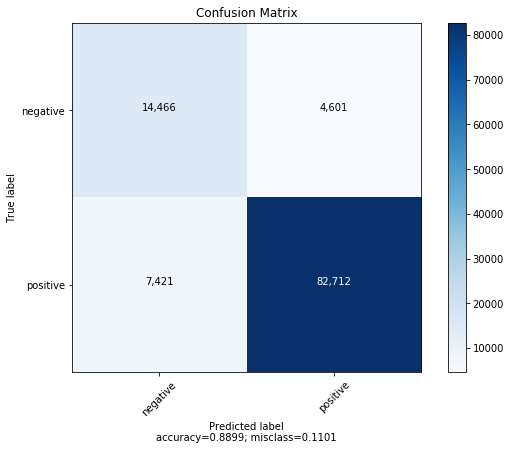

In [114]:

plot_confusion_matrix(cm           = np.array([[ 14466  ,4601],[7421 ,82712]]), 
                      normalize    = False,
                      target_names = ['negative', 'positive'],
                      title        = "Confusion Matrix")

# Logistic Regression L2 without Class balancing

In [115]:
#https://stackoverflow.com/questions/46732748/how-do-i-use-a-timeseriessplit-with-a-gridsearchcv-object-to-tune-a-model-in-sciimport xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import numpy as np
X = big_data
y = y_1
tscv = TimeSeriesSplit(n_splits=3)
Cs = [10**-4, 10**-2, 10**0, 10**2, 10**4]
model = xgb.XGBRegressor()
param_search = [{'C': [10**-2, 10**0, 3, 4, 5, 6 ,10**2]}]

my_cv = TimeSeriesSplit(n_splits=3).split(X)
gsearch = GridSearchCV(LogisticRegression(), param_search, scoring = 'accuracy', cv=my_cv)
gsearch.fit(X, y)

GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x000002156A24D360>,
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'C': [0.01, 1, 3, 4, 5, 6, 100]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [116]:
y_pred=gsearch.predict(test_data)
acc = accuracy_score(y_test, y_pred, normalize=True) * float(100)
print('\nTest accuracy for best estimator is %d%%' % ( acc))


Test accuracy for best estimator is 90%


In [117]:
gb=metrics.confusion_matrix(y_test,y_pred)
print(gb)
#plotting the confusion matrix
#Plot of Confusion Metric
#precision From above Confusion Metric
#Recall From above Confusion Metric 
recall=(gb[1,1]+0.0)/sum(gb[1,:])
pre=(gb[1,1]+0.0)/sum(gb[:,1])
F1=(2*pre*recall)/(pre+recall)
print("Precision :-",pre)
print("Recall    :-",recall)
print("F1 Score  :-",pre)

[[13111  5956]
 [ 4140 85993]]
Precision :- 0.9352249616635309
Recall    :- 0.954067877469961
F1 Score  :- 0.9352249616635309


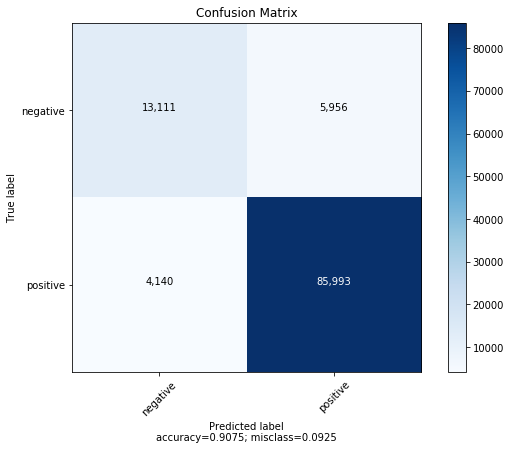

In [118]:
plot_confusion_matrix(cm           = np.array([[ 13111   ,5956],[4140  ,85993]]), 
                      normalize    = False,
                      target_names = ['negative', 'positive'],
                      title        = "Confusion Matrix")

__Misclassification error__

C:\Users\Yaakuza\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


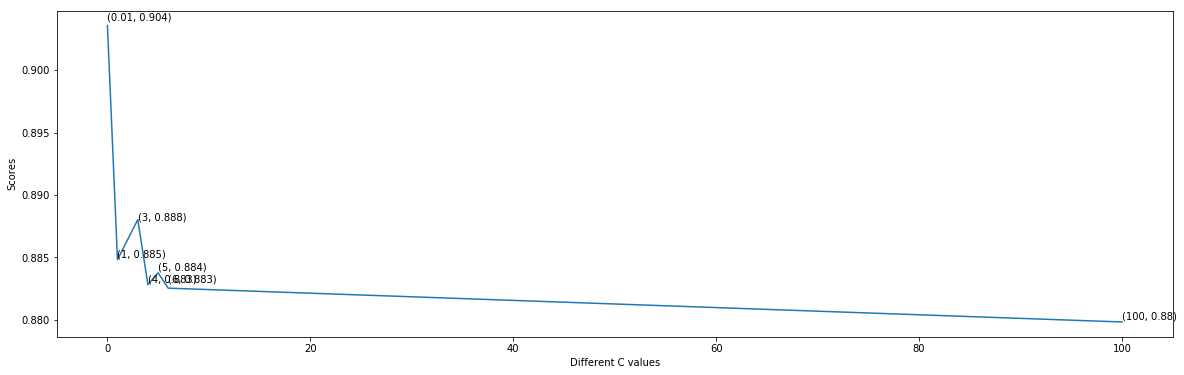

In [128]:

Cs = [10**-2, 10**0, 3, 4, 5, 6 ,10**2]
scores = [x[1] for x in gsearch.grid_scores_]
scores = np.array(scores).reshape(len(Cs))
plt.figure(figsize=(20,6))
plt.plot(Cs, scores, label='C: ' )

for xy in zip(Cs, np.round(scores,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Different C values')
plt.ylabel('Scores')
plt.show()
   

__Now using L1 Regulariser in Logistic Regrression with class balancing__

In [129]:
#https://stackoverflow.com/questions/46732748/how-do-i-use-a-timeseriessplit-with-a-gridsearchcv-object-to-tune-a-model-in-sciimport xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import numpy as np
X = big_data
y = y_1
tscv = TimeSeriesSplit(n_splits=3)

model = xgb.XGBRegressor()
param_search = [{'C': [10**-2, 10**0, 3, 4, 5, 6 ,10**2]}]

my_cv = TimeSeriesSplit(n_splits=3).split(X)
gsearch = GridSearchCV(LogisticRegression(class_weight='balanced',penalty='l1'), param_search, scoring = 'accuracy', cv=my_cv)
gsearch.fit(X, y)

GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x000002156A24DD00>,
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'C': [0.01, 1, 3, 4, 5, 6, 100]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [131]:
y_pred=gsearch.predict(test_data)
acc = accuracy_score(y_test, y_pred, normalize=True) * float(100)
print('\nTest accuracy for best estimator is %d%%' % ( acc))



Test accuracy for best estimator is 91%


In [132]:
gb=metrics.confusion_matrix(y_test,y_pred)
print(gb)
recall=(gb[1,1]+0.0)/sum(gb[1,:])
pre=(gb[1,1]+0.0)/sum(gb[:,1])
F1=(2*pre*recall)/(pre+recall)
print("Precision :-",pre)
print("Recall    :-",recall)
print("F1 Score  :-",pre)

[[16298  2769]
 [ 6968 83165]]
Precision :- 0.9677775967603044
Recall    :- 0.9226920217900214
F1 Score  :- 0.9677775967603044


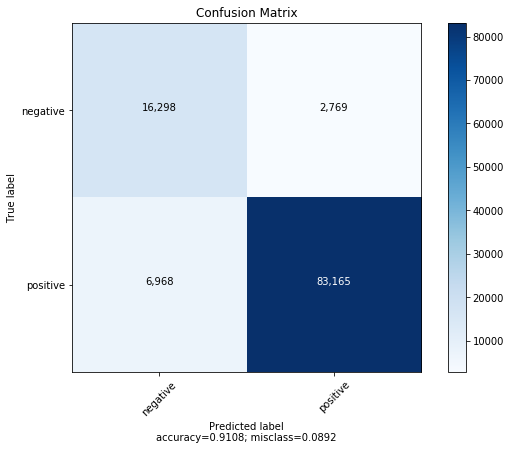

In [133]:
plot_confusion_matrix(cm           = np.array([[ 16298  ,2769],[6968  ,83165]]), 
                      normalize    = False,
                      target_names = ['negative', 'positive'],
                      title        = "Confusion Matrix")

__Now using L1 Regulariser in Logistic Regrression without class balancing__

In [134]:
#https://stackoverflow.com/questions/46732748/how-do-i-use-a-timeseriessplit-with-a-gridsearchcv-object-to-tune-a-model-in-sciimport xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import numpy as np
X = big_data
y = y_1
tscv = TimeSeriesSplit(n_splits=3)

model = xgb.XGBRegressor()
param_search = [{'C':[10**-2, 10**0, 3, 4, 5, 6 ,10**2]}]

my_cv = TimeSeriesSplit(n_splits=3).split(X)
gsearch = GridSearchCV(LogisticRegression(penalty='l1'), param_search, scoring = 'accuracy', cv=my_cv)
gsearch.fit(X, y)

GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x000002158CA4A200>,
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'C': [0.01, 1, 3, 4, 5, 6, 100]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [135]:
y_pred=gsearch.predict(test_data)
acc = accuracy_score(y_test, y_pred, normalize=True) * float(100)
print('\nTest accuracy for best estimator is %d%%' % ( acc))



Test accuracy for best estimator is 92%


In [138]:
gb=metrics.confusion_matrix(y_test,y_pred)
print(gb)
#plotting the confusion matrix
#Plot of Confusion Metric
#precision From above Confusion Metric
#Recall From above Confusion Metric 
recall=(gb[1,1]+0.0)/sum(gb[1,:])
pre=(gb[1,1]+0.0)/sum(gb[:,1])
F1=(2*pre*recall)/(pre+recall)
print("Precision :-",pre)
print("Recall    :-",recall)
print("F1 Score  :-",pre)

[[12720  6347]
 [ 2214 87919]]
Precision :- 0.9326692550866696
Recall    :- 0.9754362996904574
F1 Score  :- 0.9326692550866696


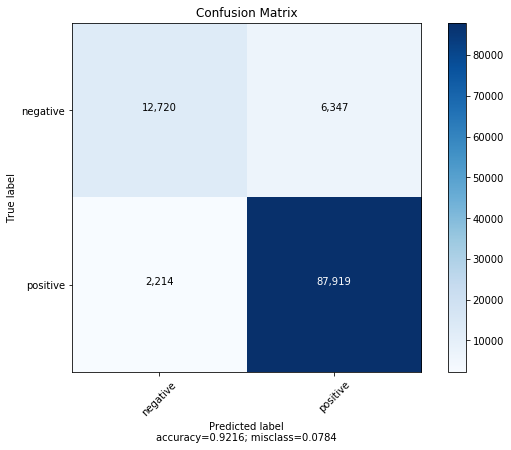

In [137]:
plot_confusion_matrix(cm           = np.array([[ 12720   ,6347],[2214   ,87919]]), 
                      normalize    = False,
                      target_names = ['negative', 'positive'],
                      title        = "Confusion Matrix")

__ Finding Sparsity of W vector for increasing values of C (Decreasing values of Lambda)__

In [139]:
#http://scikit-learn.org/stable/auto_examples/linear_model/plot_logistic_l1_l2_sparsity.html
l1_list=[0.01,0.05,0.08,1.2,2.0,10,20,30,40,70,150]
for item in l1_list:
    clf = LogisticRegression(random_state=0,penalty='l1',C=item).fit(big_data, y_1)
    #model = GridSearchCV(LogisticRegression(penalty='l1',C=item), tuned_parameters, scoring = 'accuracy', cv=5)
    #model.fit(big_data, y_1)
    coef = clf.coef_.ravel()
    sparsity_l1_LR = np.mean(coef == 0) * 100
    print("C=%.2f" % item)
    print("Sparsity with L1 penalty: %.2f%%" % sparsity_l1_LR)
    print('---------------------------------------------------------------')

C=0.01
Sparsity with L1 penalty: 83.42%
---------------------------------------------------------------
C=0.05
Sparsity with L1 penalty: 68.73%
---------------------------------------------------------------
C=0.08
Sparsity with L1 penalty: 65.77%
---------------------------------------------------------------
C=1.20
Sparsity with L1 penalty: 4.86%
---------------------------------------------------------------
C=2.00
Sparsity with L1 penalty: 3.26%
---------------------------------------------------------------
C=10.00
Sparsity with L1 penalty: 10.95%
---------------------------------------------------------------
C=20.00
Sparsity with L1 penalty: 48.23%
---------------------------------------------------------------
C=30.00
Sparsity with L1 penalty: 25.11%
---------------------------------------------------------------
C=40.00
Sparsity with L1 penalty: 2.78%
---------------------------------------------------------------
C=70.00
Sparsity with L1 penalty: 45.15%
----------------------

__As we can see with different values of C i.e inverse of Lambda the sparsity of w* vector is changing.__
1. as C increases (lambda decreases) the sparsity decreases. i.e as lambda increases the sparsity also increases
2. this proves the fact that in L1 regurarization when lambda increases the sparsity also increases 

##### We are printing the top words which have the highest probablity in  positive and negative reviews.

In [141]:
clf = LogisticRegression(C=5).fit(big_data, y_1)
clf.predict(test_data)
wv=clf.coef_
abs_weights = np.abs(wv)

In [142]:
sorted(wv)

hm=wv[-1:]
hm

array([[-0.03763285,  0.0424076 ,  0.06205551, ...,  0.00851973,
         0.01122439,  0.00209671]])

In [147]:
def show_most_informative_features(vectorizer, clf, n=25):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    print("\t\t\tNEGATIVE\t\t\t\t\t\tPOSITIVE")
    print("________________________________________________________________________________________________")
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))
        
show_most_informative_features(count_vect,clf)
#Code Reference:https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers

			NEGATIVE						POSITIVE
________________________________________________________________________________________________
	-0.9690	not            				1.1551	great          
	-0.4221	worst          				0.9005	best           
	-0.3282	terrible       				0.7989	delicious      
	-0.3080	awful          				0.7150	good           
	-0.3035	horrible       				0.6766	perfect        
	-0.2932	disappointed   				0.6101	love           
	-0.2779	taste          				0.5686	excellent      
	-0.2492	mimalist       				0.4906	nice           
	-0.2492	roccoco        				0.4859	highly         
	-0.2491	unfortunately  				0.4373	loves          
	-0.2485	threw          				0.4280	wonderful      
	-0.2466	don            				0.4167	tasty          
	-0.2420	didn           				0.3986	awesome        
	-0.2416	worse          				0.3948	smooth         
	-0.2390	disappointing  				0.3789	favorite       
	-0.2386	even           				0.3718	easy           
	-0.2385	was            				0.3705	amazing        
	-0.2345	n

## Perturbation Test

In [163]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 8, penalty= 'l2')
clf.fit(big_data,y_1)
y_pred = clf.predict(test_data)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 90.031%
Non Zero weights: 95227


In [172]:
from scipy.sparse import find
#Weights before adding random noise
w1 = find(clf.coef_[0])[2]


In [173]:
from scipy.sparse import find

#epsilon = np.random.normal(loc=0.0, scale=0.00000001)
epsilon = np.random.uniform(low=-0.0001, high=0.0001, size=(find(X_train_t)[0].size,))
new_data = big_data.copy()
#Random noise
#Getting the postions(row and column) and value of non-zero datapoints 
a,b,c = find(new_data)

#Introducing random noise to non-zero datapoints
new_data[a,b] = epsilon + new_data[a,b] 

In [174]:
#Training on train data having random noise
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 9, penalty= 'l2')
clf.fit(new_data,y_1)
y_pred = clf.predict(test_data)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 90.501%
Non Zero weights: 95227


In [175]:
w2.shape

(95227,)

In [176]:
w1.shape

(95227,)

In [177]:
#Weights after adding random noise
w2 = find(clf.coef_[0])[2]


In [178]:
diff = (abs(w1 - w2)/w1) * 100

In [179]:
print(diff[np.where(diff > 30)].size)

19475


__""We have 19475 feature whose weight changed more then 30 percent""__

In [181]:
from scipy.spatial import distance
from scipy import spatial
dst = distance.euclidean(w1, w2)
result = 1 - spatial.distance.cosine(w1,w2)
print("Euclidean distance between two vectors is:-",dst)
print("Cosine similarity between two vectors is:-",result)

Euclidean distance between two vectors is:- 3.3933380398798656
Cosine similarity between two vectors is:- 0.9640771628150064


### Now Computing Using Tf-Idf Features

In [183]:
#Tf-IDF for 254800 Train points
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
big_data = tf_idf_vect.fit_transform(X_1['Text'].values)
print(big_data.shape)


(254800, 2301100)


In [184]:
#Tf-Idf for 109200 Test points
test_data = tf_idf_vect.transform(X_test['Text'].values)
print(test_data.shape)

(109200, 2301100)


##### Standardizing our Train and Test BOW vectors 

In [185]:
#from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler
standardizedtest_data = StandardScaler(with_mean=False).fit_transform(test_data)
print(standardizedtest_data.shape)
test_data=standardizedtest_data

(109200, 2301100)


In [186]:
#from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler
standardized_data = StandardScaler(with_mean=False).fit_transform(big_data)
print(standardized_data.shape)

(254800, 2301100)


In [187]:
big_data=standardized_data

# Logistic Regression With CLASS - BALANCING

In [188]:
#https://stackoverflow.com/questions/46732748/how-do-i-use-a-timeseriessplit-with-a-gridsearchcv-object-to-tune-a-model-in-sciimport xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import numpy as np
X = big_data
y = y_1
tscv = TimeSeriesSplit(n_splits=3)

model = xgb.XGBRegressor()
param_search = [{'C': [10**-2, 10**0, 3, 4, 5, 6 ,10**2]}]

my_cv = TimeSeriesSplit(n_splits=3).split(X)
gsearch = GridSearchCV(LogisticRegression(class_weight='balanced'), param_search, scoring = 'accuracy', cv=my_cv)
gsearch.fit(X, y)

GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x00000215BC1D3F68>,
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'C': [0.01, 1, 3, 4, 5, 6, 100]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [189]:
y_pred=gsearch.predict(test_data)
acc = accuracy_score(y_test, y_pred, normalize=True) * float(100)
print('\nTest accuracy for best estimator is %d%%' % ( acc))


Test accuracy for best estimator is 90%


#### Confusion matrix , Precision, Recall, F-Score

In [190]:
# print the confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn import metrics
gb=metrics.confusion_matrix(y_test,y_pred)
print(gb)
#plotting the confusion matrix
#Plot of Confusion Metric
#precision From above Confusion Metric
#Recall From above Confusion Metric 
recall=(gb[1,1]+0.0)/sum(gb[1,:])
pre=(gb[1,1]+0.0)/sum(gb[:,1])
F1=(2*pre*recall)/(pre+recall)
print("Precision :-",pre)
print("Recall    :-",recall)
print("F1 Score  :-",pre)

[[ 9697  9370]
 [  637 89496]]
Precision :- 0.9052252543847228
Recall    :- 0.9929326661711027
F1 Score  :- 0.9052252543847228


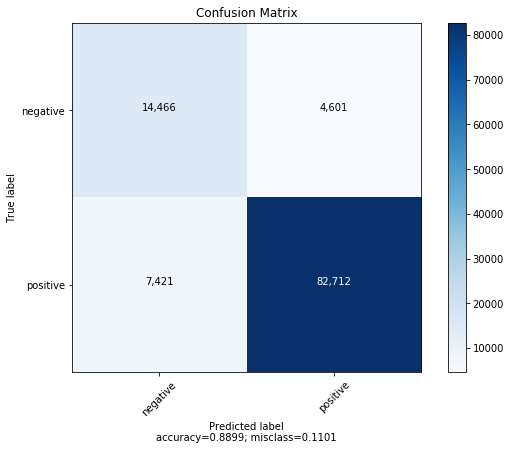

In [191]:

plot_confusion_matrix(cm           = np.array([[ 14466  ,4601],[7421 ,82712]]), 
                      normalize    = False,
                      target_names = ['negative', 'positive'],
                      title        = "Confusion Matrix")

# Logistic Regression L2 without Class balancing

In [192]:
#https://stackoverflow.com/questions/46732748/how-do-i-use-a-timeseriessplit-with-a-gridsearchcv-object-to-tune-a-model-in-sciimport xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import numpy as np
X = big_data
y = y_1
tscv = TimeSeriesSplit(n_splits=3)
Cs = [10**-4, 10**-2, 10**0, 10**2, 10**4]
model = xgb.XGBRegressor()
param_search = [{'C': [10**-2, 10**0, 3, 4, 5, 6 ,10**2]}]

my_cv = TimeSeriesSplit(n_splits=3).split(X)
gsearch = GridSearchCV(LogisticRegression(), param_search, scoring = 'accuracy', cv=my_cv)
gsearch.fit(X, y)

GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x00000215D9EC9780>,
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'C': [0.01, 1, 3, 4, 5, 6, 100]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [193]:
y_pred=gsearch.predict(test_data)
acc = accuracy_score(y_test, y_pred, normalize=True) * float(100)
print('\nTest accuracy for best estimator is %d%%' % ( acc))


Test accuracy for best estimator is 90%


In [194]:
gb=metrics.confusion_matrix(y_test,y_pred)
print(gb)
#plotting the confusion matrix
#Plot of Confusion Metric
#precision From above Confusion Metric
#Recall From above Confusion Metric 
recall=(gb[1,1]+0.0)/sum(gb[1,:])
pre=(gb[1,1]+0.0)/sum(gb[:,1])
F1=(2*pre*recall)/(pre+recall)
print("Precision :-",pre)
print("Recall    :-",recall)
print("F1 Score  :-",pre)

[[ 9223  9844]
 [  577 89556]]
Precision :- 0.9009657947686117
Recall    :- 0.9935983491063206
F1 Score  :- 0.9009657947686117


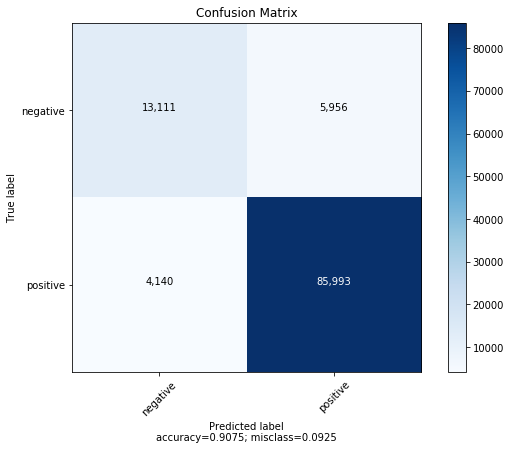

In [195]:
plot_confusion_matrix(cm           = np.array([[ 13111   ,5956],[4140  ,85993]]), 
                      normalize    = False,
                      target_names = ['negative', 'positive'],
                      title        = "Confusion Matrix")

__Misclassification error__

C:\Users\Yaakuza\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


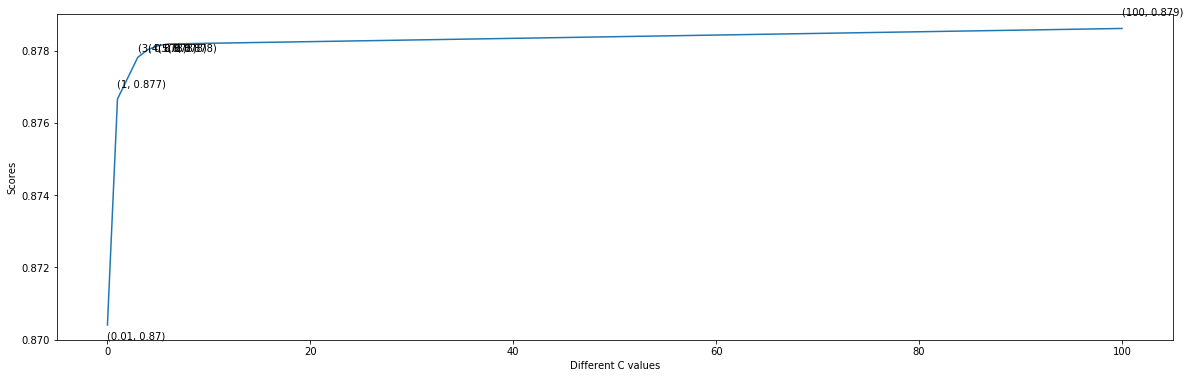

In [196]:

Cs = [10**-2, 10**0, 3, 4, 5, 6 ,10**2]
scores = [x[1] for x in gsearch.grid_scores_]
scores = np.array(scores).reshape(len(Cs))
plt.figure(figsize=(20,6))
plt.plot(Cs, scores, label='C: ' )

for xy in zip(Cs, np.round(scores,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Different C values')
plt.ylabel('Scores')
plt.show()
   

__Now using L1 Regulariser in Logistic Regrression with class balancing__

In [197]:
#https://stackoverflow.com/questions/46732748/how-do-i-use-a-timeseriessplit-with-a-gridsearchcv-object-to-tune-a-model-in-sciimport xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import numpy as np
X = big_data
y = y_1
tscv = TimeSeriesSplit(n_splits=3)

model = xgb.XGBRegressor()
param_search = [{'C': [10**-2, 10**0, 3, 4, 5, 6 ,10**2]}]

my_cv = TimeSeriesSplit(n_splits=3).split(X)
gsearch = GridSearchCV(LogisticRegression(class_weight='balanced',penalty='l1'), param_search, scoring = 'accuracy', cv=my_cv)
gsearch.fit(X, y)

GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x00000215D9EC99E8>,
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'C': [0.01, 1, 3, 4, 5, 6, 100]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [198]:
y_pred=gsearch.predict(test_data)
acc = accuracy_score(y_test, y_pred, normalize=True) * float(100)
print('\nTest accuracy for best estimator is %d%%' % ( acc))



Test accuracy for best estimator is 93%


In [199]:
gb=metrics.confusion_matrix(y_test,y_pred)
print(gb)
recall=(gb[1,1]+0.0)/sum(gb[1,:])
pre=(gb[1,1]+0.0)/sum(gb[:,1])
F1=(2*pre*recall)/(pre+recall)
print("Precision :-",pre)
print("Recall    :-",recall)
print("F1 Score  :-",pre)

[[14730  4337]
 [ 2287 87846]]
Precision :- 0.9529522797045008
Recall    :- 0.9746263854526089
F1 Score  :- 0.9529522797045008


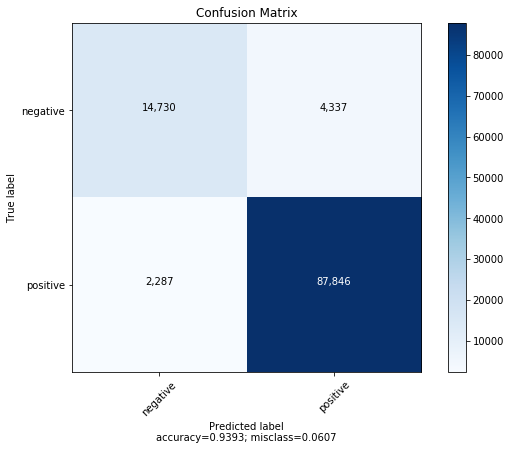

In [221]:
plot_confusion_matrix(cm           = np.array([[ 14730 ,4337],[2287 ,87846]]), 
                      normalize    = False,
                      target_names = ['negative', 'positive'],
                      title        = "Confusion Matrix")

__Now using L1 Regulariser in Logistic Regrression without class balancing__

In [201]:
#https://stackoverflow.com/questions/46732748/how-do-i-use-a-timeseriessplit-with-a-gridsearchcv-object-to-tune-a-model-in-sciimport xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import numpy as np
X = big_data
y = y_1
tscv = TimeSeriesSplit(n_splits=3)

model = xgb.XGBRegressor()
param_search = [{'C':[10**-2, 10**0, 3, 4, 5, 6 ,10**2]}]

my_cv = TimeSeriesSplit(n_splits=3).split(X)
gsearch = GridSearchCV(LogisticRegression(penalty='l1'), param_search, scoring = 'accuracy', cv=my_cv)
gsearch.fit(X, y)

GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x0000021526D1C048>,
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'C': [0.01, 1, 3, 4, 5, 6, 100]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [202]:
y_pred=gsearch.predict(test_data)
acc = accuracy_score(y_test, y_pred, normalize=True) * float(100)
print('\nTest accuracy for best estimator is %d%%' % ( acc))



Test accuracy for best estimator is 93%


In [203]:
gb=metrics.confusion_matrix(y_test,y_pred)
print(gb)
#plotting the confusion matrix
#Plot of Confusion Metric
#precision From above Confusion Metric
#Recall From above Confusion Metric 
recall=(gb[1,1]+0.0)/sum(gb[1,:])
pre=(gb[1,1]+0.0)/sum(gb[:,1])
F1=(2*pre*recall)/(pre+recall)
print("Precision :-",pre)
print("Recall    :-",recall)
print("F1 Score  :-",pre)

[[13056  6011]
 [ 1215 88918]]
Precision :- 0.9366789916674567
Recall    :- 0.9865199205618363
F1 Score  :- 0.9366789916674567


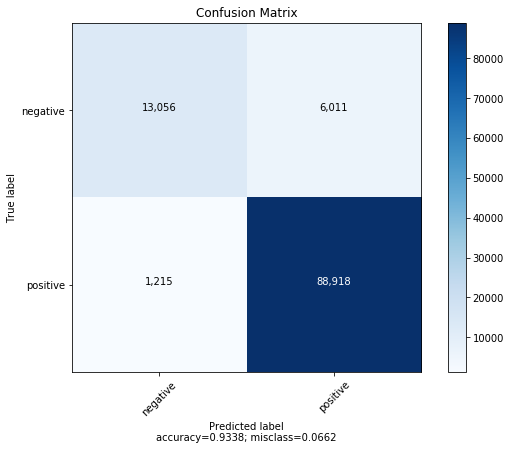

In [220]:
plot_confusion_matrix(cm           = np.array([[ 13056     ,6011],[1215    ,88918]]), 
                      normalize    = False,
                      target_names = ['negative', 'positive'],
                      title        = "Confusion Matrix")

__ Finding Sparsity of W vector for increasing values of C (Decreasing values of Lambda)__

In [205]:
#http://scikit-learn.org/stable/auto_examples/linear_model/plot_logistic_l1_l2_sparsity.html
l1_list=[0.01,0.05,0.08,1.2,2.0,10,20,30,40,70,150]
for item in l1_list:
    clf = LogisticRegression(random_state=0,penalty='l1',C=item).fit(big_data, y_1)
    #model = GridSearchCV(LogisticRegression(penalty='l1',C=item), tuned_parameters, scoring = 'accuracy', cv=5)
    #model.fit(big_data, y_1)
    coef = clf.coef_.ravel()
    sparsity_l1_LR = np.mean(coef == 0) * 100
    print("C=%.2f" % item)
    print("Sparsity with L1 penalty: %.2f%%" % sparsity_l1_LR)
    print('---------------------------------------------------------------')

C=0.01
Sparsity with L1 penalty: 96.70%
---------------------------------------------------------------
C=0.05
Sparsity with L1 penalty: 95.11%
---------------------------------------------------------------
C=0.08
Sparsity with L1 penalty: 95.42%
---------------------------------------------------------------
C=1.20
Sparsity with L1 penalty: 94.74%
---------------------------------------------------------------
C=2.00
Sparsity with L1 penalty: 94.01%
---------------------------------------------------------------
C=10.00
Sparsity with L1 penalty: 91.82%
---------------------------------------------------------------
C=20.00
Sparsity with L1 penalty: 90.24%
---------------------------------------------------------------
C=30.00
Sparsity with L1 penalty: 86.19%
---------------------------------------------------------------
C=40.00
Sparsity with L1 penalty: 90.59%
---------------------------------------------------------------
C=70.00
Sparsity with L1 penalty: 88.96%
-------------------

__As we can see with different values of C i.e inverse of Lambda the sparsity of w* vector is changing.__
1. as C increases (lambda decreases) the sparsity decreases. i.e as lambda increases the sparsity also increases
2. this proves the fact that in L1 regurarization when lambda increases the sparsity also increases 

##### We are printing the top words which have the highest probablity in  positive and negative reviews.

In [206]:
clf = LogisticRegression(C=5).fit(big_data, y_1)
clf.predict(test_data)
wv=clf.coef_
abs_weights = np.abs(wv)

In [207]:
sorted(wv)

hm=wv[-1:]
hm

array([[-0.01356872, -0.0006246 , -0.000544  , ...,  0.00082314,
         0.00072629,  0.00072629]])

In [208]:
def show_most_informative_features(vectorizer, clf, n=25):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    print("\t\t\tNEGATIVE\t\t\t\t\t\tPOSITIVE")
    print("________________________________________________________________________________________________")
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))
        
show_most_informative_features(count_vect,clf)
#Code Reference:https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers

			NEGATIVE						POSITIVE
________________________________________________________________________________________________
	-0.0325	drive          				0.0518	yowie          
	-0.0308	greenpowder    				0.0353	lindas         
	-0.0275	snackalicious  				0.0339	greese         
	-0.0271	stylish        				0.0308	unfavorable    
	-0.0245	017            				0.0299	menial         
	-0.0243	fancifully     				0.0292	mcqueen        
	-0.0243	ktoo           				0.0281	flutterby2554  
	-0.0239	leamonade      				0.0265	fleisch        
	-0.0238	familiar       				0.0262	flipped        
	-0.0236	primia         				0.0245	grinz          
	-0.0232	splashed       				0.0242	street         
	-0.0229	vinci          				0.0234	whammy         
	-0.0224	smothered      				0.0232	mechs          
	-0.0217	titch          				0.0229	grubex         
	-0.0217	snippit        				0.0229	median         
	-0.0213	8013           				0.0221	sluicing       
	-0.0208	rustica        				0.0220	whow           
	-0.0207	a

## Perturbation Test

In [209]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 8, penalty= 'l2')
clf.fit(big_data,y_1)
y_pred = clf.predict(test_data)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 90.470%
Non Zero weights: 2301100


In [210]:
from scipy.sparse import find
#Weights before adding random noise
w1 = find(clf.coef_[0])[2]


In [212]:
from scipy.sparse import find

#epsilon = np.random.normal(loc=0.0, scale=0.00000001)
epsilon = np.random.uniform(low=-0.0001, high=0.0001, size=(find(big_data)[0].size,))
new_data = big_data.copy()
#Random noise
#Getting the postions(row and column) and value of non-zero datapoints 
a,b,c = find(new_data)

#Introducing random noise to non-zero datapoints
new_data[a,b] = epsilon + new_data[a,b] 

In [213]:
#Training on train data having random noise
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 9, penalty= 'l2')
clf.fit(new_data,y_1)
y_pred = clf.predict(test_data)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 90.233%
Non Zero weights: 2301100


In [214]:
w2.shape

(95227,)

In [215]:
w1.shape

(2301100,)

In [216]:
#Weights after adding random noise
w2 = find(clf.coef_[0])[2]


In [217]:
diff = (abs(w1 - w2)/w1) * 100

In [218]:
print(diff[np.where(diff > 30)].size)

287753



__""We have 287753 feature whose beight changed more then 30 percent""__

In [219]:
from scipy.spatial import distance
from scipy import spatial
dst = distance.euclidean(w1, w2)
result = 1 - spatial.distance.cosine(w1,w2)
print("Euclidean distance between two vectors is:-",dst)
print("Cosine similarity between two vectors is:-",result)

Euclidean distance between two vectors is:- 0.31236802981925144
Cosine similarity between two vectors is:- 0.9972256090202093


__Now Trying on Word2Vec__

In [228]:
# Train your own Word2Vec model using your own text corpus for train Data
import gensim
i=0
list_of_sent_train=[]
for sent in X_1['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent_train.append(filtered_sentence)
    

In [229]:
# min_count = 5 considers only words that occured atleast 5 times
import gensim
from gensim import models
from gensim.models import Word2Vec, KeyedVectors
w2v_model=Word2Vec(list_of_sent_train,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  28914
sample words  ['this', 'witty', 'little', 'book', 'makes', 'my', 'son', 'laugh', 'at', 'loud', 'i', 'it', 'in', 'the', 'car', 'as', 'were', 'driving', 'along', 'and', 'he', 'always', 'can', 'sing', 'refrain', 'hes', 'learned', 'about', 'whales', 'india', 'drooping', 'love', 'all', 'new', 'words', 'introduces', 'silliness', 'of', 'is', 'a', 'classic', 'am', 'willing', 'to', 'bet', 'will', 'still', 'be', 'able', 'from']


In [231]:

# average Word2Vec
# compute average word2vec for each review.
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_train: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))

254800
50


In [230]:
# Train your own Word2Vec model using your own text corpus for test Data
import gensim
i=0
list_of_sent_test=[]
for sent in X_test['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent_test.append(filtered_sentence)
    

In [232]:
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sent_test,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  19804
sample words  ['the', 'only', 'good', 'comment', 'i', 'can', 'give', 'on', 'these', 'treats', 'is', 'that', 'my', 'cat', 'liked', 'them', 'when', 'they', 'were', 'fresh', 'and', 'are', 'really', 'inexpensive', 'usually', 'find', 'for', 'under', 'two', 'dollars', 'at', 'grocery', 'or', 'pet', 'store', 'even', 'occasion', 'dollar', 'as', 'this', 'treat', 'proves', 'often', 'with', 'a', 'low', 'price', 'comes', 'cheap', 'product']


In [234]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

109200
50


##### Standardizing our Train and Test word2vec vectors 

In [235]:
#from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler
#np.isnan(sent_vectors_train.values.any())
#Where sent_vectors_train is my pandas Dataframe 
standardized_data_train = StandardScaler(with_mean=False).fit_transform(sent_vectors_train)
print(standardized_data_train.shape)

(254800, 50)


In [236]:
#from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler
standardized_data_test = StandardScaler(with_mean=False).fit_transform(sent_vectors_test)
print(standardized_data_test.shape)

(109200, 50)


In [237]:
big_data=standardized_data_train

In [238]:
X=big_data
test_data=standardized_data_test
y=y_1

# Logistic Regression With CLASS - BALANCING

In [239]:
#https://stackoverflow.com/questions/46732748/how-do-i-use-a-timeseriessplit-with-a-gridsearchcv-object-to-tune-a-model-in-sciimport xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import numpy as np
X = big_data
y = y_1
tscv = TimeSeriesSplit(n_splits=3)

model = xgb.XGBRegressor()
param_search = [{'C': [10**-2, 10**0, 3, 4, 5, 6 ,10**2]}]

my_cv = TimeSeriesSplit(n_splits=3).split(X)
gsearch = GridSearchCV(LogisticRegression(class_weight='balanced'), param_search, scoring = 'accuracy', cv=my_cv)
gsearch.fit(X, y)

GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x00000216DD28EE08>,
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'C': [0.01, 1, 3, 4, 5, 6, 100]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [240]:
y_pred=gsearch.predict(test_data)
acc = accuracy_score(y_test, y_pred, normalize=True) * float(100)
print('\nTest accuracy for best estimator is %d%%' % ( acc))


Test accuracy for best estimator is 82%


#### Confusion matrix , Precision, Recall, F-Score

In [241]:
# print the confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn import metrics
gb=metrics.confusion_matrix(y_test,y_pred)
print(gb)
#plotting the confusion matrix
#Plot of Confusion Metric
#precision From above Confusion Metric
#Recall From above Confusion Metric 
recall=(gb[1,1]+0.0)/sum(gb[1,:])
pre=(gb[1,1]+0.0)/sum(gb[:,1])
F1=(2*pre*recall)/(pre+recall)
print("Precision :-",pre)
print("Recall    :-",recall)
print("F1 Score  :-",pre)

[[   12 19055]
 [   29 90104]]
Precision :- 0.8254381223719528
Recall    :- 0.999678253247978
F1 Score  :- 0.8254381223719528


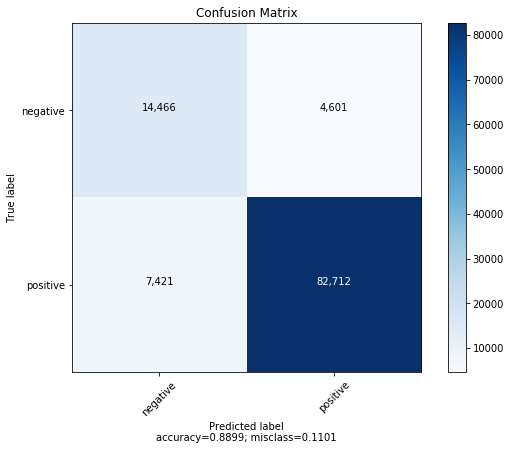

In [242]:

plot_confusion_matrix(cm           = np.array([[ 14466  ,4601],[7421 ,82712]]), 
                      normalize    = False,
                      target_names = ['negative', 'positive'],
                      title        = "Confusion Matrix")

# Logistic Regression L2 without Class balancing

In [243]:
#https://stackoverflow.com/questions/46732748/how-do-i-use-a-timeseriessplit-with-a-gridsearchcv-object-to-tune-a-model-in-sciimport xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import numpy as np
X = big_data
y = y_1
tscv = TimeSeriesSplit(n_splits=3)
Cs = [10**-4, 10**-2, 10**0, 10**2, 10**4]
model = xgb.XGBRegressor()
param_search = [{'C': [10**-2, 10**0, 3, 4, 5, 6 ,10**2]}]

my_cv = TimeSeriesSplit(n_splits=3).split(X)
gsearch = GridSearchCV(LogisticRegression(), param_search, scoring = 'accuracy', cv=my_cv)
gsearch.fit(X, y)

GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x00000216DD28E888>,
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'C': [0.01, 1, 3, 4, 5, 6, 100]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [244]:
y_pred=gsearch.predict(test_data)
acc = accuracy_score(y_test, y_pred, normalize=True) * float(100)
print('\nTest accuracy for best estimator is %d%%' % ( acc))


Test accuracy for best estimator is 82%


In [245]:
gb=metrics.confusion_matrix(y_test,y_pred)
print(gb)
#plotting the confusion matrix
#Plot of Confusion Metric
#precision From above Confusion Metric
#Recall From above Confusion Metric 
recall=(gb[1,1]+0.0)/sum(gb[1,:])
pre=(gb[1,1]+0.0)/sum(gb[:,1])
F1=(2*pre*recall)/(pre+recall)
print("Precision :-",pre)
print("Recall    :-",recall)
print("F1 Score  :-",pre)

[[    3 19064]
 [   25 90108]]
Precision :- 0.8253764701571832
Recall    :- 0.9997226321103259
F1 Score  :- 0.8253764701571832


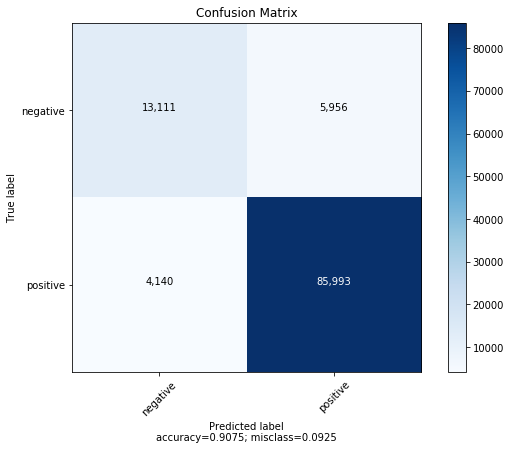

In [246]:
plot_confusion_matrix(cm           = np.array([[ 13111   ,5956],[4140  ,85993]]), 
                      normalize    = False,
                      target_names = ['negative', 'positive'],
                      title        = "Confusion Matrix")

__Misclassification error__

C:\Users\Yaakuza\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


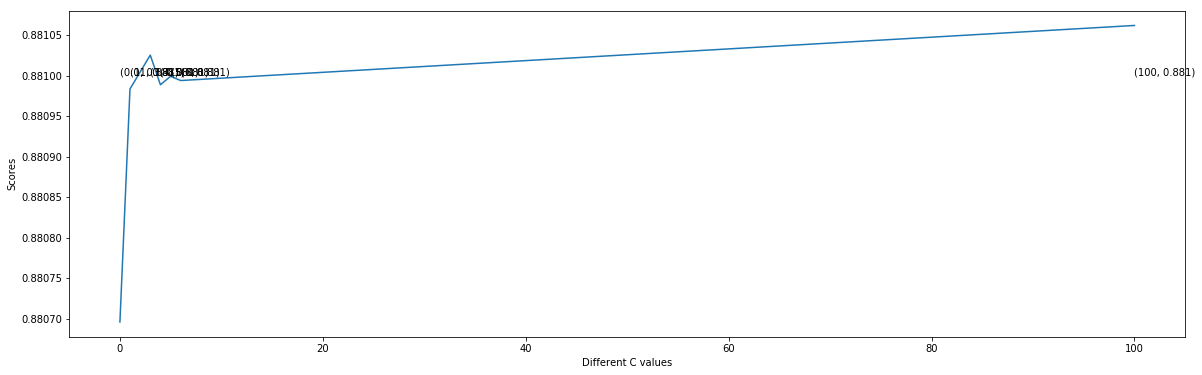

In [247]:

Cs = [10**-2, 10**0, 3, 4, 5, 6 ,10**2]
scores = [x[1] for x in gsearch.grid_scores_]
scores = np.array(scores).reshape(len(Cs))
plt.figure(figsize=(20,6))
plt.plot(Cs, scores, label='C: ' )

for xy in zip(Cs, np.round(scores,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Different C values')
plt.ylabel('Scores')
plt.show()
   

__Now using L1 Regulariser in Logistic Regrression with class balancing__

In [248]:
#https://stackoverflow.com/questions/46732748/how-do-i-use-a-timeseriessplit-with-a-gridsearchcv-object-to-tune-a-model-in-sciimport xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import numpy as np
X = big_data
y = y_1
tscv = TimeSeriesSplit(n_splits=3)

model = xgb.XGBRegressor()
param_search = [{'C': [10**-2, 10**0, 3, 4, 5, 6 ,10**2]}]

my_cv = TimeSeriesSplit(n_splits=3).split(X)
gsearch = GridSearchCV(LogisticRegression(class_weight='balanced',penalty='l1'), param_search, scoring = 'accuracy', cv=my_cv)
gsearch.fit(X, y)

GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x00000216BC8CA0F8>,
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'C': [0.01, 1, 3, 4, 5, 6, 100]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [249]:
y_pred=gsearch.predict(test_data)
acc = accuracy_score(y_test, y_pred, normalize=True) * float(100)
print('\nTest accuracy for best estimator is %d%%' % ( acc))



Test accuracy for best estimator is 82%


In [250]:
gb=metrics.confusion_matrix(y_test,y_pred)
print(gb)
recall=(gb[1,1]+0.0)/sum(gb[1,:])
pre=(gb[1,1]+0.0)/sum(gb[:,1])
F1=(2*pre*recall)/(pre+recall)
print("Precision :-",pre)
print("Recall    :-",recall)
print("F1 Score  :-",pre)

[[   13 19054]
 [   29 90104]]
Precision :- 0.8254456842375273
Recall    :- 0.999678253247978
F1 Score  :- 0.8254456842375273


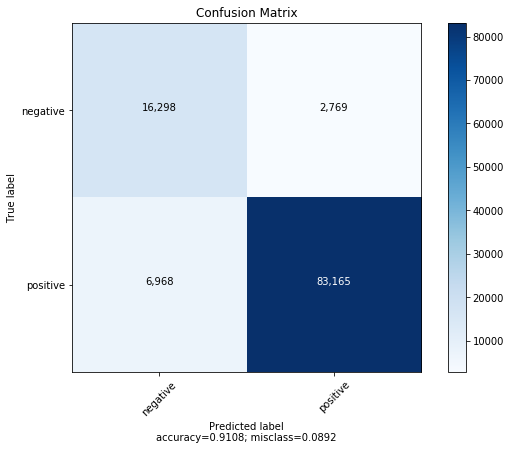

In [251]:
plot_confusion_matrix(cm           = np.array([[ 16298  ,2769],[6968  ,83165]]), 
                      normalize    = False,
                      target_names = ['negative', 'positive'],
                      title        = "Confusion Matrix")

__Now using L1 Regulariser in Logistic Regrression without class balancing__

In [252]:
#https://stackoverflow.com/questions/46732748/how-do-i-use-a-timeseriessplit-with-a-gridsearchcv-object-to-tune-a-model-in-sciimport xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import numpy as np
X = big_data
y = y_1
tscv = TimeSeriesSplit(n_splits=3)

model = xgb.XGBRegressor()
param_search = [{'C':[10**-2, 10**0, 3, 4, 5, 6 ,10**2]}]

my_cv = TimeSeriesSplit(n_splits=3).split(X)
gsearch = GridSearchCV(LogisticRegression(penalty='l1'), param_search, scoring = 'accuracy', cv=my_cv)
gsearch.fit(X, y)

GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x00000216BC8CA570>,
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'C': [0.01, 1, 3, 4, 5, 6, 100]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [253]:
y_pred=gsearch.predict(test_data)
acc = accuracy_score(y_test, y_pred, normalize=True) * float(100)
print('\nTest accuracy for best estimator is %d%%' % ( acc))



Test accuracy for best estimator is 82%


In [254]:
gb=metrics.confusion_matrix(y_test,y_pred)
print(gb)
#plotting the confusion matrix
#Plot of Confusion Metric
#precision From above Confusion Metric
#Recall From above Confusion Metric 
recall=(gb[1,1]+0.0)/sum(gb[1,:])
pre=(gb[1,1]+0.0)/sum(gb[:,1])
F1=(2*pre*recall)/(pre+recall)
print("Precision :-",pre)
print("Recall    :-",recall)
print("F1 Score  :-",pre)

[[    6 19061]
 [   25 90108]]
Precision :- 0.8253991517738553
Recall    :- 0.9997226321103259
F1 Score  :- 0.8253991517738553


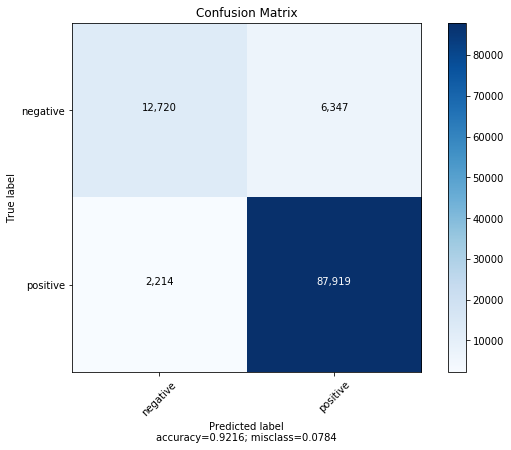

In [255]:
plot_confusion_matrix(cm           = np.array([[ 12720   ,6347],[2214   ,87919]]), 
                      normalize    = False,
                      target_names = ['negative', 'positive'],
                      title        = "Confusion Matrix")

__ Finding Sparsity of W vector for increasing values of C (Decreasing values of Lambda)__

In [256]:
#http://scikit-learn.org/stable/auto_examples/linear_model/plot_logistic_l1_l2_sparsity.html
l1_list=[0.01,0.05,0.08,1.2,2.0,10,20,30,40,70,150]
for item in l1_list:
    clf = LogisticRegression(random_state=0,penalty='l1',C=item).fit(big_data, y_1)
    #model = GridSearchCV(LogisticRegression(penalty='l1',C=item), tuned_parameters, scoring = 'accuracy', cv=5)
    #model.fit(big_data, y_1)
    coef = clf.coef_.ravel()
    sparsity_l1_LR = np.mean(coef == 0) * 100
    print("C=%.2f" % item)
    print("Sparsity with L1 penalty: %.2f%%" % sparsity_l1_LR)
    print('---------------------------------------------------------------')

C=0.01
Sparsity with L1 penalty: 6.00%
---------------------------------------------------------------
C=0.05
Sparsity with L1 penalty: 2.00%
---------------------------------------------------------------
C=0.08
Sparsity with L1 penalty: 0.00%
---------------------------------------------------------------
C=1.20
Sparsity with L1 penalty: 0.00%
---------------------------------------------------------------
C=2.00
Sparsity with L1 penalty: 0.00%
---------------------------------------------------------------
C=10.00
Sparsity with L1 penalty: 0.00%
---------------------------------------------------------------
C=20.00
Sparsity with L1 penalty: 0.00%
---------------------------------------------------------------
C=30.00
Sparsity with L1 penalty: 0.00%
---------------------------------------------------------------
C=40.00
Sparsity with L1 penalty: 0.00%
---------------------------------------------------------------
C=70.00
Sparsity with L1 penalty: 0.00%
-----------------------------

__As we can see with different values of C i.e inverse of Lambda the sparsity of w* vector is changing.__
1. as C increases (lambda decreases) the sparsity decreases. i.e as lambda increases the sparsity also increases
2. this proves the fact that in L1 regurarization when lambda increases the sparsity also increases 

## Perturbation Test

In [260]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 8, penalty= 'l2')
clf.fit(big_data,y_1)
y_pred = clf.predict(test_data)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 82.519%
Non Zero weights: 50


In [261]:
from scipy.sparse import find
#Weights before adding random noise
w1 = find(clf.coef_[0])[2]


In [263]:
from scipy.sparse import find

#epsilon = np.random.normal(loc=0.0, scale=0.00000001)
epsilon = np.random.uniform(low=-0.0001, high=0.0001, size=(find(big_data)[0].size,))
new_data = big_data.copy()
#Random noise
#Getting the postions(row and column) and value of non-zero datapoints 
a,b,c = find(new_data)

#Introducing random noise to non-zero datapoints
new_data[a,b] = epsilon + new_data[a,b] 

In [264]:
#Training on train data having random noise
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 9, penalty= 'l2')
clf.fit(new_data,y_1)
y_pred = clf.predict(test_data)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 82.519%
Non Zero weights: 50


In [265]:
w2.shape

(2301100,)

In [266]:
w1.shape

(50,)

In [267]:
#Weights after adding random noise
w2 = find(clf.coef_[0])[2]


In [268]:
diff = (abs(w1 - w2)/w1) * 100

In [269]:
print(diff[np.where(diff > 30)].size)

0


__""We have 0 feature whose beight changed more then 30 percent""__

In [270]:
from scipy.spatial import distance
from scipy import spatial
dst = distance.euclidean(w1, w2)
result = 1 - spatial.distance.cosine(w1,w2)
print("Euclidean distance between two vectors is:-",dst)
print("Cosine similarity between two vectors is:-",result)

Euclidean distance between two vectors is:- 0.006495788187743015
Cosine similarity between two vectors is:- 0.9999998264554264


### Conclusion / Summary